In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
%load_ext autoreload
%autoreload 2

import seaborn as sns
from matplotlib import rcParams

### Import connectivity graph and permutation related functions.

In [2]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import permtest_leiden_pairs

###  Useful plotting functions

In [3]:
def plot_zscores(df, title='title', shape=[1, 2],
                 loc1=[0, 0], loc2=[0, 1]):
    hm = df.pivot('leiden.i', 'leiden.j', 'z.score')
    annot = df.pivot('leiden.i', 'leiden.j', 'n.obs')

    plt.subplot2grid(shape, loc1, rowspan=1, colspan=1)
    plt.hist(np.array(hm).flatten(), bins=100);
    plt.xlabel('z-score')
    plt.ylabel('density')

    vmax = max(hm.max())
    vmin = -5 # vmax
    # print(vmin, vmax)
    idx = hm.index.astype(int).sort_values().astype(int)
    # print(idx)

    plt.subplot2grid(shape, loc2, rowspan=1, colspan=1)
    sns.heatmap(hm.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                annot=annot.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                fmt='.0f',
                cmap='Reds', vmin=0, vmax=vmax,
                cbar_kws={'label': 'Z-score'},
                annot_kws={'fontsize': 5}, xticklabels=True, yticklabels=True)
    plt.title('Co-enrichment of pairs in connectivity graph (%s)' % (title))
    plt.tight_layout()
    
def plot_nodes_heatmap(results, vmax=None):
    hm = results.pivot('leiden.i', 'leiden.j', 'z.score')
    vmax = vmax if vmax is None else max(hm.max())
    annot = nodes.pivot('leiden.i', 'leiden.j', 'n.obs')
    g = sns.clustermap(hm.fillna(0),
                       cmap='Reds', vmin=0, vmax=vmax, cbar_kws={'label': 'Z-score'})
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.subplots_adjust(right=.5, bottom=.7)
    
def plot_permtest_complex(res):
    rcParams['figure.figsize'] = [15, 5]
    rcParams['figure.dpi'] = 100
    pi = 0
    colors_top = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628"]
    
    ymin = int(min(res['z.score']) - 5)
    ymax = int(max(res['z.score']) + 5)
    for mode, grp in res.groupby('mode'):
        plt.subplot(1, 3, pi + 1)
        max_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').set_index('k')['z.score'].to_dict()
        color_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').head(len(colors_top)).set_index('k')
        color_by_k['color'] = colors_top
        color_by_k = color_by_k['color'].to_dict()
        for k, grp2 in grp.groupby(['k']):
            n_perm = list(set(grp2['n.perm']))[0]
            # print(k, sel.shape)
            plt.plot(grp2['n.rings'], grp2['z.score'], c=color_by_k[k] if k in color_by_k else 'gray',
                    label=k if k in color_by_k else '',
                    lw=2.0 if k in color_by_k else .1);
            plt.xlabel('connectivity degree')
            plt.ylabel('Z-score');
            plt.title('by %s' % mode)
        plt.legend(fontsize=8);
        plt.ylim([ymin, ymax])
        pi += 1
        
def show_top6(adata, res, by='nodes'):
    rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 8))
    ax = ax.flatten()
    sel = res[res['mode'] == by].sort_values('z.score', ascending=False).drop_duplicates('k.sorted').head(6)
    ki = 0
    for ri, r in sel.iterrows():
        obs = r['n.obs']
        exp = r['n.exp']
        nrings = r['n.rings']
        z = r['z.score']
        k = r['k.sorted']
        title = '%s, rings=%i\nobs=%i, nexp=%i\nZ=%.1f' % (k, nrings, obs, exp, z)
        # print(ki, title)
        sc.pl.spatial(adata, color ="leiden", groups=set(k.split(':')),
                      ax = ax[ki], show = False, title = title, size=1.5)
        ki += 1
    plt.tight_layout()


In [4]:
def get_adata():
    # path to "raw" dataset folder
    BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
    dataset_name = "V1_Adult_Mouse_Brain"
    dataset_folder = os.path.join(
        BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
    )
    adata = sc.read_visium(
        dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
    )
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)    
    return adata

### Pre-processing to ensure data be ready for permutations functions

In [5]:
adata = get_adata()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Big test (10x visium data)

In [6]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

In [7]:
spatial_connectivity(adata, n_rings=3)
conn = adata.obsp['spatial_connectivities']

sc.pp.neighbors(adata)
sc.tl.leiden(adata)

leiden = adata.obs['leiden']
N = adata.shape[0]
positions = np.arange(N) # .reshape(w, h)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [8]:
n_permutations = 100

In [9]:
permtest_leiden_pairs(adata, count_option='edges',
                              print_log_each=25, n_permutations=n_permutations)
edges = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...


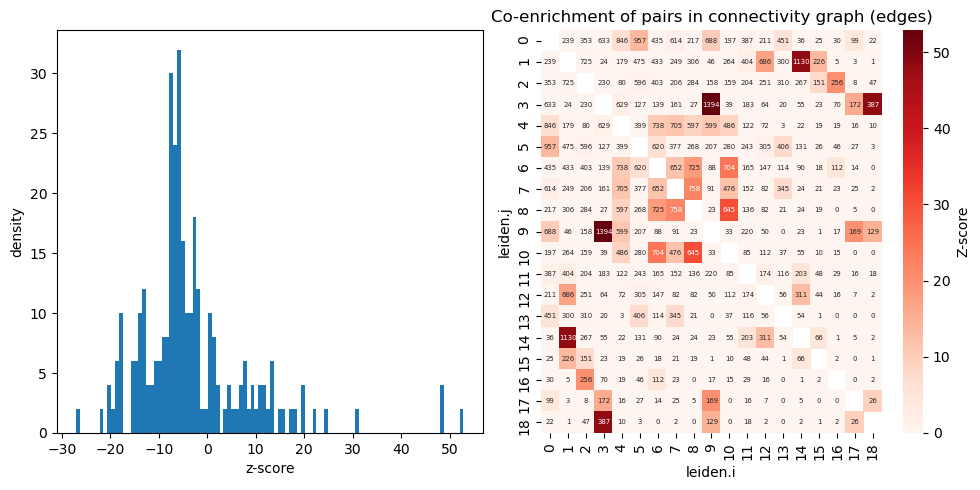

In [10]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [10, 5]
plot_zscores(edges, title='edges')

In [11]:
permtest_leiden_pairs(adata, n_permutations=n_permutations, count_option='nodes')
nodes = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...


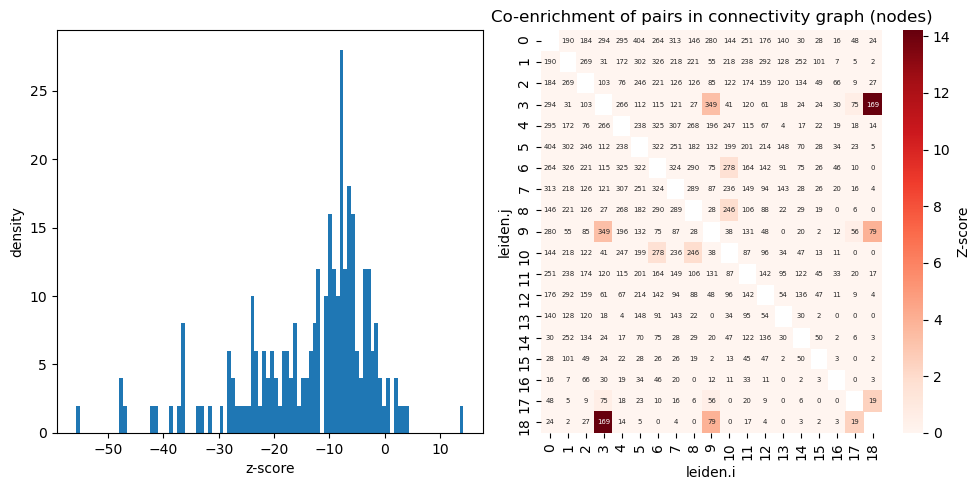

In [12]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [10, 5]
plot_zscores(nodes, title='nodes')

### Check based on nodes clusters that seemed of interest

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


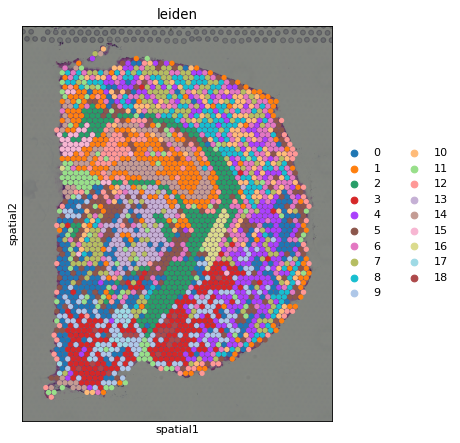

In [13]:
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = [5, 8]
sc.pl.spatial(adata, color = "leiden", size=1.5)

... storing 'leiden.query' as categorical


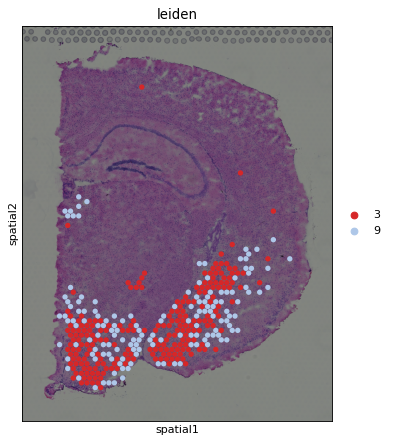

In [14]:
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = [5, 8]

settest = {'9', '3'}
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest, size=1.5);

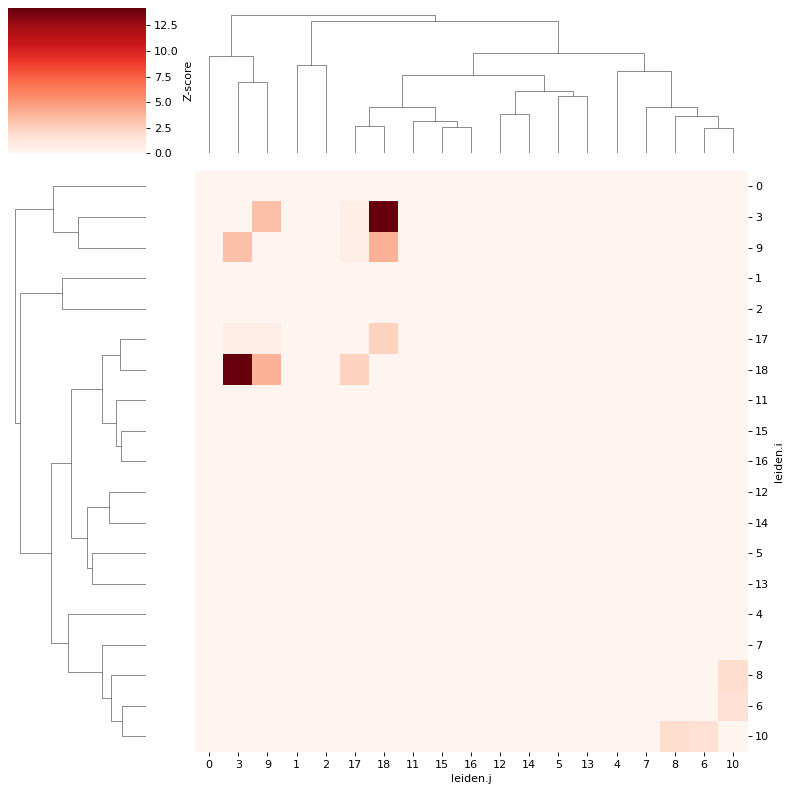

In [15]:
plot_nodes_heatmap(nodes)
plt.tight_layout()

### Permtest Z-scores for increasing connectivity values (~2 min based on parameters with 200 permutations each)

In [16]:
res = permtest_leiden_pairs_complex(adata, rings_start=1, rings_end=5, n_perm=100)

# degree 1
calculating connectivity graph with degree 1...
permutations with mode edges...
permutations with mode nodes...
# degree 2
calculating connectivity graph with degree 2...
permutations with mode edges...
permutations with mode nodes...
# degree 3
calculating connectivity graph with degree 3...
permutations with mode edges...
permutations with mode nodes...
# degree 4
calculating connectivity graph with degree 4...
permutations with mode edges...
permutations with mode nodes...


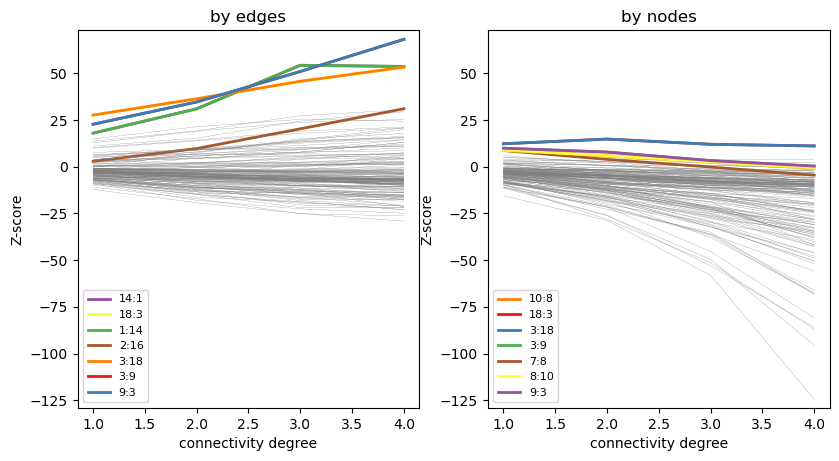

In [17]:
plot_permtest_complex(res)

In [18]:
res[(res['mode'] == 'nodes')].sort_values('z.score', ascending=False).head()

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted,n.rings,n.perm
65,18,3,129,nodes,18:3,220,21,14.752360,43.48,5.797039,3:18,2,100
65,3,18,129,nodes,3:18,220,21,14.752360,43.48,5.797039,3:18,2,100
65,18,3,77,nodes,18:3,220,21,12.238688,18.57,4.774205,3:18,1,100
65,3,18,77,nodes,3:18,220,21,12.238688,18.57,4.774205,3:18,1,100
65,3,18,169,nodes,3:18,220,21,11.957554,70.84,8.209037,3:18,3,100


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden.query' as categorical


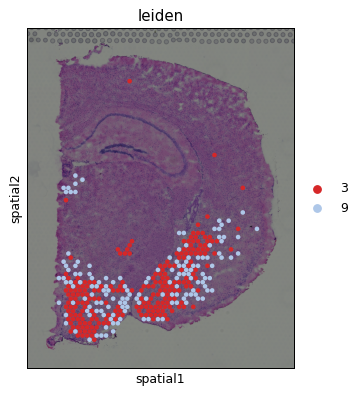

In [19]:
settest = {'3', '9'}
rcParams['figure.dpi'] = 90
rcParams['figure.figsize'] = [5, 5]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest, size=1.5)

In [20]:
res[res['mode'] == 'edges'].sort_values('z.score', ascending=False).drop_duplicates('k.sorted').head(6)

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted,n.rings,n.perm
56,3,9,2296,edges,3:9,220,147,68.124598,664.42,23.949939,3:9,4,100
30,1,14,1130,edges,1:14,251,104,54.234928,326.55,14.814254,1:14,3,100
65,3,18,589,edges,3:18,220,21,53.254138,93.17,9.310638,3:18,4,100
48,2,16,477,edges,2:16,226,29,30.979327,133.87,11.076096,2:16,4,100
117,8,10,1022,edges,8:10,154,123,30.455543,392.12,20.681949,8:10,4,100
133,17,9,289,edges,17:9,147,21,29.411084,65.50,7.599176,9:17,4,100


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden.query' as categorical


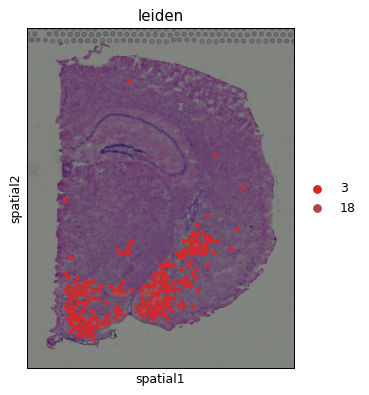

In [21]:
settest = {'3', '18'}
rcParams['figure.dpi'] = 90
rcParams['figure.figsize'] = [5, 5]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest, size=1.5)

### Show top 6 cases

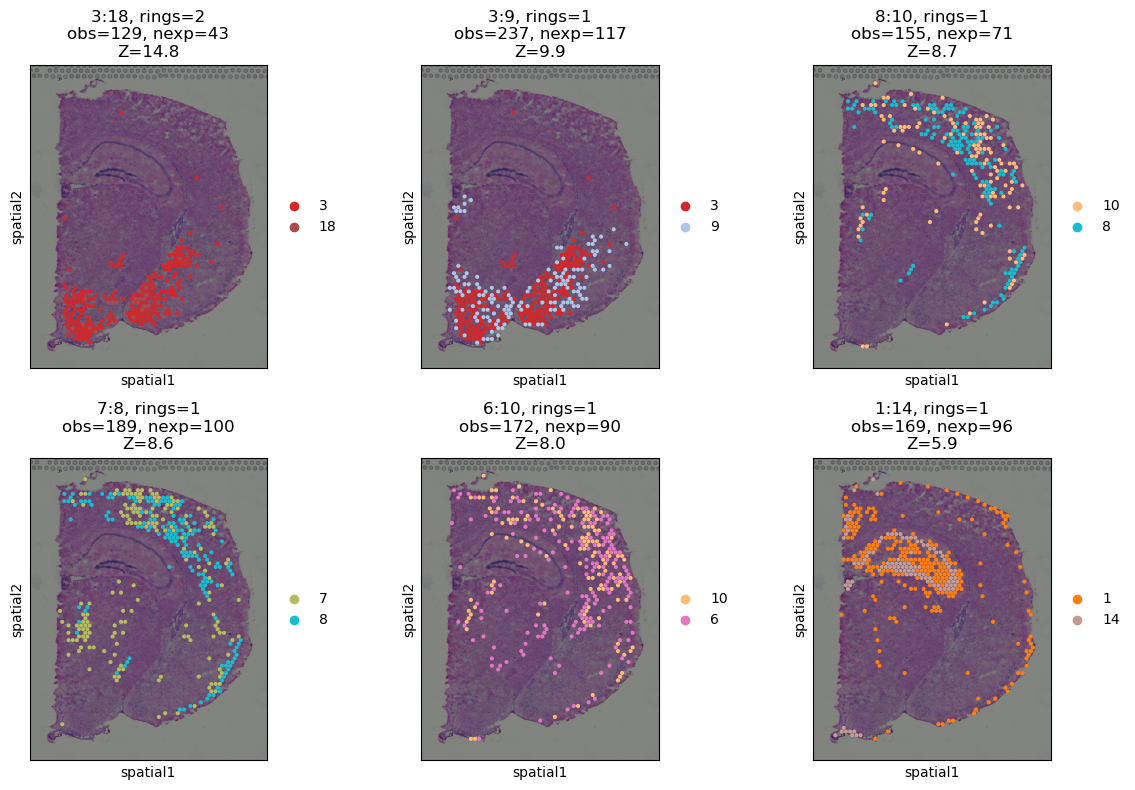

In [22]:
show_top6(adata, res, by='nodes')

In [23]:
res[(res['mode'] == 'edges') & (res['n.rings'] == 1)].sort_values('z.score', ascending=False).drop_duplicates('k.sorted').head(6)

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted,n.rings,n.perm
65,3,18,82,edges,3:18,220,21,27.587888,9.39,2.631952,3:18,1,100
56,3,9,240,edges,3:9,220,147,22.686573,70.11,7.488570,3:9,1,100
30,14,1,174,edges,14:1,251,104,17.920840,56.90,6.534292,1:14,1,100
105,7,8,159,edges,7:8,179,154,14.794114,59.85,6.701990,7:8,1,100
117,10,8,125,edges,10:8,154,123,13.608192,40.46,6.212435,8:10,1,100
96,10,6,141,edges,10:6,194,123,12.660150,52.39,6.999127,6:10,1,100


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


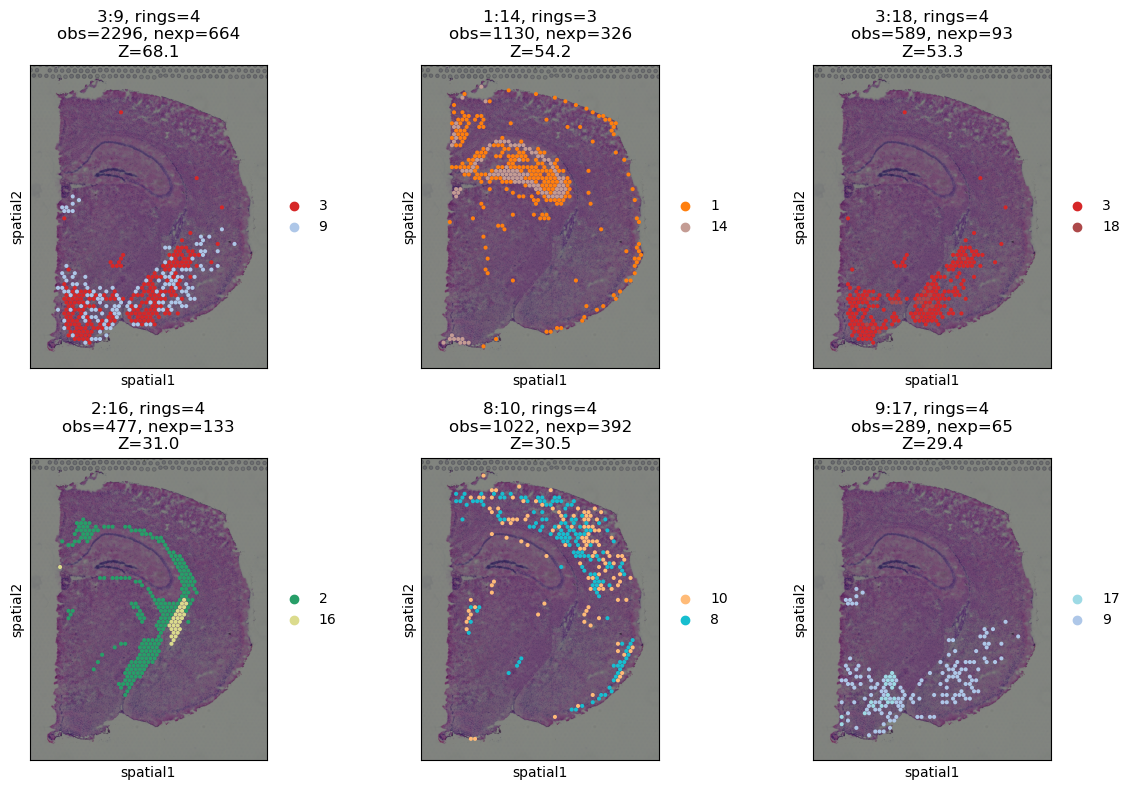

In [24]:
show_top6(adata, res, by='edges')

###  Agreement between scores (by ring)
Here we plot the z-scores by ring to check its agreement by N rings

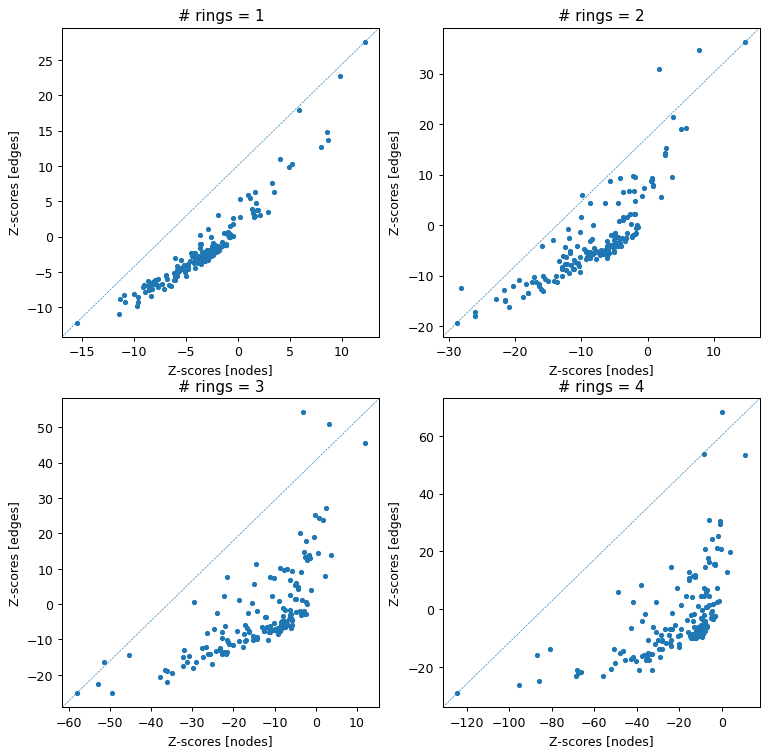

In [25]:
pi = 0
for ring, grp in res.groupby('n.rings'):
    rcParams['figure.dpi'] = 90
    rcParams['figure.figsize'] = [10, 10]
    ax = plt.subplot(2, 2, pi + 1)
    e = grp[grp['mode'] == 'edges'].drop_duplicates('k.sorted')
    n = grp[grp['mode'] == 'nodes'].drop_duplicates('k.sorted')
    hm = pd.concat([e, n]).pivot('k.sorted', 'mode', 'z.score')
    plt.scatter(hm['nodes'], hm['edges'], s=10)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', lw=.5)
    plt.xlabel('Z-scores [nodes]')
    plt.ylabel('Z-scores [edges]')
    plt.title('# rings = %i' % ring)
    pi += 1

In [26]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=10, count_option='edges')
edges = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
10 permutations (out of 100)...
20 permutations (out of 100)...
30 permutations (out of 100)...
40 permutations (out of 100)...
50 permutations (out of 100)...
60 permutations (out of 100)...
70 permutations (out of 100)...
80 permutations (out of 100)...
90 permutations (out of 100)...
100 permutations (out of 100)...
CPU times: user 44.5 s, sys: 26.1 ms, total: 44.6 s
Wall time: 44.9 s


In [27]:
%time permtest_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes')
nodes = adata.uns['nhood_permtest'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations (n=100)...
Please consider a high permutation value for reliable Z-score estimates (>500)...
25 permutations (out of 100)...
50 permutations (out of 100)...
75 permutations (out of 100)...
100 permutations (out of 100)...
CPU times: user 45 s, sys: 5.49 s, total: 50.5 s
Wall time: 51.1 s
